In [1]:
import pandas as pd
import numpy as np
import os


# Scientific question
how does transcription profile change with dengue disease?

goal: identify biomarkers

In [2]:
data_df         = pd.read_csv(os.path.join("data", "dengue", "small_transcriptome", "denv.csv"), header=None).T
data_df.columns = data_df.iloc[0]
data_df         = data_df.iloc[1:]
data_df

,Sample_title,Sample_geo_accession,Sample_status,Sample_submission_date,Sample_last_update_date,Sample_type,Sample_channel_count,Sample_source_name_ch1,Sample_organism_ch1,Sample_characteristics_ch1,...,Sample_contact_department,Sample_contact_institute,Sample_contact_address,Sample_contact_city,Sample_contact_state,Sample_contact_zip/postal_code,Sample_contact_country,Sample_supplementary_file,Sample_data_row_count,ID_REF
1,1-001-1,GSM3519420,Public on Feb 04 2019,Dec 18 2018,Feb 04 2019,RNA,1,whole blood from dengue infected patient,Homo sapiens,tissue: whole blood from dengue infected patient,...,Medicine,Stanford University,"279 Campus Dr., Beckman B235A",Stanford,CA,94305,USA,NONE,0,GSM3519420
2,1-001-2,GSM3519421,Public on Feb 04 2019,Dec 18 2018,Feb 04 2019,RNA,1,whole blood from dengue infected patient,Homo sapiens,tissue: whole blood from dengue infected patient,...,Medicine,Stanford University,"279 Campus Dr., Beckman B235A",Stanford,CA,94305,USA,NONE,0,GSM3519421
3,1-001-3,GSM3519422,Public on Feb 04 2019,Dec 18 2018,Feb 04 2019,RNA,1,whole blood from dengue infected patient,Homo sapiens,tissue: whole blood from dengue infected patient,...,Medicine,Stanford University,"279 Campus Dr., Beckman B235A",Stanford,CA,94305,USA,NONE,0,GSM3519422
4,1-001-4,GSM3519423,Public on Feb 04 2019,Dec 18 2018,Feb 04 2019,RNA,1,whole blood from dengue infected patient,Homo sapiens,tissue: whole blood from dengue infected patient,...,Medicine,Stanford University,"279 Campus Dr., Beckman B235A",Stanford,CA,94305,USA,NONE,0,GSM3519423
5,1-002-1,GSM3519424,Public on Feb 04 2019,Dec 18 2018,Feb 04 2019,RNA,1,whole blood from dengue infected patient,Homo sapiens,tissue: whole blood from dengue infected patient,...,Medicine,Stanford University,"279 Campus Dr., Beckman B235A",Stanford,CA,94305,USA,NONE,0,GSM3519424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,3-020-01,GSM3519518,Public on Feb 04 2019,Dec 18 2018,Feb 04 2019,RNA,1,whole blood from healthy control,Homo sapiens,tissue: whole blood from healthy control,...,Medicine,Stanford University,"279 Campus Dr., Beckman B235A",Stanford,CA,94305,USA,NONE,0,GSM3519518
100,3-021-01,GSM3519519,Public on Feb 04 2019,Dec 18 2018,Feb 04 2019,RNA,1,whole blood from healthy control,Homo sapiens,tissue: whole blood from healthy control,...,Medicine,Stanford University,"279 Campus Dr., Beckman B235A",Stanford,CA,94305,USA,NONE,0,GSM3519519
101,3-022-01,GSM3519520,Public on Feb 04 2019,Dec 18 2018,Feb 04 2019,RNA,1,whole blood from healthy control,Homo sapiens,tissue: whole blood from healthy control,...,Medicine,Stanford University,"279 Campus Dr., Beckman B235A",Stanford,CA,94305,USA,NONE,0,GSM3519520
102,3-023-01,GSM3519521,Public on Feb 04 2019,Dec 18 2018,Feb 04 2019,RNA,1,whole blood from healthy control,Homo sapiens,tissue: whole blood from healthy control,...,Medicine,Stanford University,"279 Campus Dr., Beckman B235A",Stanford,CA,94305,USA,NONE,0,GSM3519521


In [3]:
# data_df = data_df.drop(columns=["Sample_organism_ch1", "Sample_type",
#                        "Sample_last_update_date", "Sample_contact_address",
#                        "Sample_contact_city",     "Sample_contact_state",
#                        "Sample_contact_country",  "Sample_supplementary_file", "series_matrix_table_end",
#                        'Sample_data_processing', 'Sample_platform_id', 'Sample_contact_name',
#                        'Sample_contact_email', 'Sample_contact_department'])

data_df["diagnosis"]  = data_df["diagnosis"].apply(lambda x: x.split(": ")[1])
data_df["patient_ID"] = data_df["Sample_title"].apply(lambda x: "-".join(x.split("-")[:-1]))

data_disease_df = data_df[["patient_ID", "diagnosis"]]
#data_disease_df = data_disease_df[data_disease_df.diagnosis != "exclude"]
data_disease_df["patient_diag"] = data_disease_df["patient_ID"] + "_" + data_disease_df["diagnosis"]
patient2diag_dict = dict(zip(data_disease_df["patient_ID"], data_disease_df["diagnosis"]))


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_83866/1540439605.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_disease_df["patient_diag"] = data_disease_df["patient_ID"] + "_" + data_disease_df["diagnosis"]


In [ ]:
def modify_patient_id_gene_expression(patient_id):
    l = patient_id.split("-")
    if len(l) == 3:
        return "-".join(l[:-1])
    else:
        return "-".join(l)

gene_expression_df = pd.read_excel(os.path.join("data", "dengue",  "small_transcriptome", "denv_pcr.xlsx"))
gene_expression_df = gene_expression_df[gene_expression_df["patient_ID"]!="3-004-01"]


gene_expression_df["patient_ID"] = gene_expression_df["patient_ID"].apply(modify_patient_id_gene_expression)
gene_expression_df["diagnosis"]  = gene_expression_df["patient_ID"].apply(lambda x: patient2diag_dict[x])
gene_expression_df               = gene_expression_df[gene_expression_df["diagnosis"] != "exclude"]
gene_expression_df

,patient_ID,plate_ID,mRNA,Value,Quality,Call,Threshold,diagnosis
0,1-010,S16-A04,PTPRM,20.817483,0.925333,Pass,0.004331,DSS
1,1-010,S16-A01,AAK1,17.748183,0.795321,Pass,0.001502,DSS
2,1-010,S16-A02,BMP2K,17.294386,0.798279,Pass,0.003788,DSS
3,1-010,S16-A03,ENPP5,29.129949,0.662016,Pass,0.001880,DSS
4,1-010,S16-A08,C3orf18,22.489814,0.767580,Pass,0.003659,DSS
...,...,...,...,...,...,...,...,...
10219,1-024,S33-A34,TMEM63C,26.533032,0.567610,Pass,0.001819,DF
10220,1-024,S33-A35,EMPTY,40.000000,0.000000,No Call,0.001819,DF
10221,1-024,S33-A02,BMP2K,40.000000,0.000000,Pass,0.001819,DF
10222,1-024,S33-A04,PTPRM,22.472190,0.900244,Pass,0.001819,DF


In [14]:
gene_expression_df.patient_ID.unique(), len(gene_expression_df.patient_ID.unique())

(array(['1-010', '1-013', '1-014', '1-016', '1-017', '1-018', '1-019',
        '1-001', '3-005', '1-002', '3-006', '1-003', '3-007', '1-004',
        '3-008', '1-007', '1-008', '3-013', '3-014', '3-015', '3-016',
        '3-017', '3-018', '3-019', '3-020', '3-021', '3-022', '3-023',
        '3-024', '3-009', '3-010', '3-011', '3-012', '1-029', '1-030',
        '1-031', '1-032', '1-033', '1-034', '1-035', '1-038', '1-020',
        '1-039', '1-040', '1-041', '1-021', '1-022', '1-023', '1-024',
        '1-026', '1-027', '1-028', '1-036'], dtype=object),
 53)

In [5]:
gene_expression_df.mRNA.unique().shape

(35,)

In [6]:
gene_expression_df[gene_expression_df.diagnosis == "healthy"]

,patient_ID,plate_ID,mRNA,Value,Quality,Call,Threshold,diagnosis
1152,3-005,S39-A32,CLINT1,17.687078,0.616781,Pass,0.001904,healthy
1153,3-005,S39-A34,TMEM63C,22.870306,0.724105,Pass,0.002593,healthy
1154,3-005,S39-A35,EMPTY,40.000000,0.000000,No Call,0.000735,healthy
1155,3-005,S39-A36,EMPTY,40.000000,0.000000,No Call,0.000735,healthy
1156,3-005,S39-A33,KIFF11,20.460867,0.885726,Pass,0.003649,healthy
...,...,...,...,...,...,...,...,...
4315,3-012,S04-A38,CX3CR1,23.081331,0.372557,Pass,0.002325,healthy
4316,3-012,S04-A23,EMPTY,40.000000,0.000000,No Call,0.000987,healthy
4317,3-012,S04-A40,TOR3A,40.000000,0.000000,Pass,0.001345,healthy
4318,3-012,S04-A13,AK5,20.497336,0.315988,Pass,0.002211,healthy


In [32]:
a     = np.array([1, 2, 3, 4, 5])
train = np.sort(np.random.choice(a, 3))


test_D = set(a) - set(train)
print("train data:", train, "test possible data;", list(test_D))

train data: [1 2 3] test possible data; [4, 5]


In [ ]:
random_normal_samples = np.random.normal(0, 0.4, 1000000)
random_normal_samples

bootstrap_sample = np.random.choice(random_normal_samples, 10)

np.mean(bootstrap_sample)

0.20923102824832948

In [10]:
import numpy as np

μ_real                = 10
σ_real                = 0.4
random_normal_samples = np.random.normal(μ_real, 0.4, 1000000)

nb_explore   = np.arange(1, 10000)
pred_acc_all = np.full(nb_explore.shape, np.nan)
var_all      = np.full(nb_explore.shape, np.nan)

for i_b, Nb in enumerate(nb_explore):
    bootstrap_sample = np.random.choice(random_normal_samples, Nb)
    pred_acc = np.mean(bootstrap_sample)

    pred_acc_all[i_b] = pred_acc
    var_all[i_b]      = np.std(bootstrap_sample)

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_88173/2037739243.py:4: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(nb_explore, var_all * nb_explore / (nb_explore - 1))


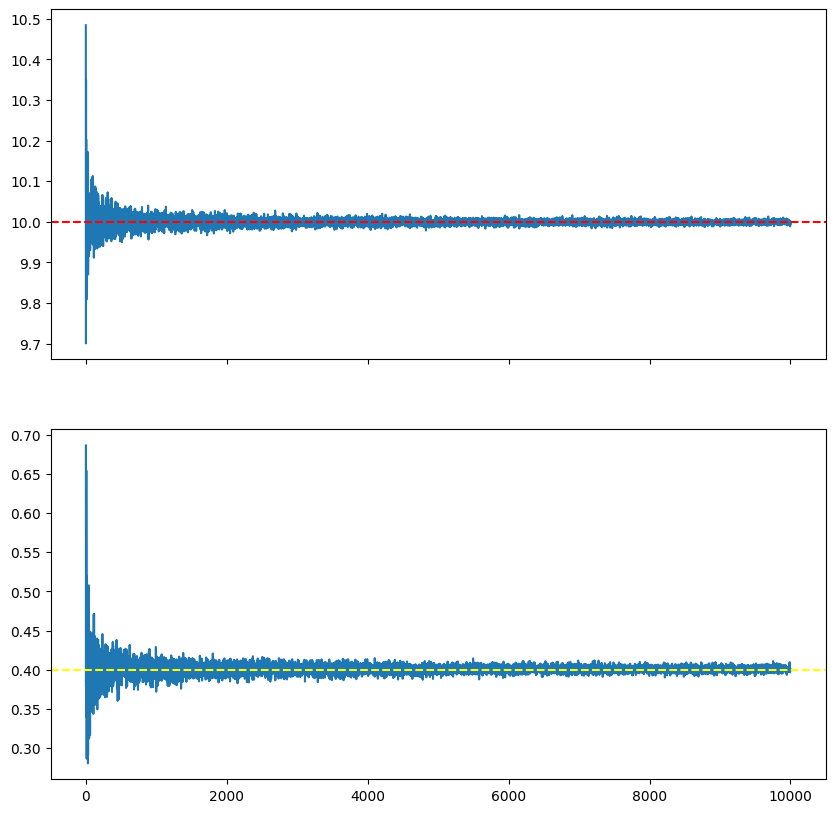

In [14]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax[0].plot(nb_explore, pred_acc_all)
ax[1].plot(nb_explore, var_all * nb_explore / (nb_explore - 1))

ax[0].axhline(μ_real, color = 'r',      linestyle = '--')
ax[1].axhline(0.4,    color = 'yellow', linestyle = '--')

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(2, 1, figsize=(10.2, 9.2))

ax[0].hist(np.log(gene_expression_df["Value"].values), edgecolor="w", facecolor="salmon",
                                                                alpha=0.5, bins=20)

gene_expression_df["log_Value"] = np.log(gene_expression_df["Value"].values)
sns.histplot(ax       = ax[1],
            data      = gene_expression_df,
            x         = "log_Value",
            hue       = "diagnosis",
            edgecolor = "w",
            bins    = 20,
            palette = "Set2")
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)

for axi in ax.flatten():
    axi.spines["top"].set_visible(False)
    axi.spines["right"].set_visible(False)

fig.supxlabel("RNA expression", weight="bold")
fig.supylabel("count", weight="bold")


KeyboardInterrupt: 

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/866531282.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_expression2_df["log_Value"] = np.log(gene_expression2_df["Value"].values)


Text(0.02, 0.5, 'count')

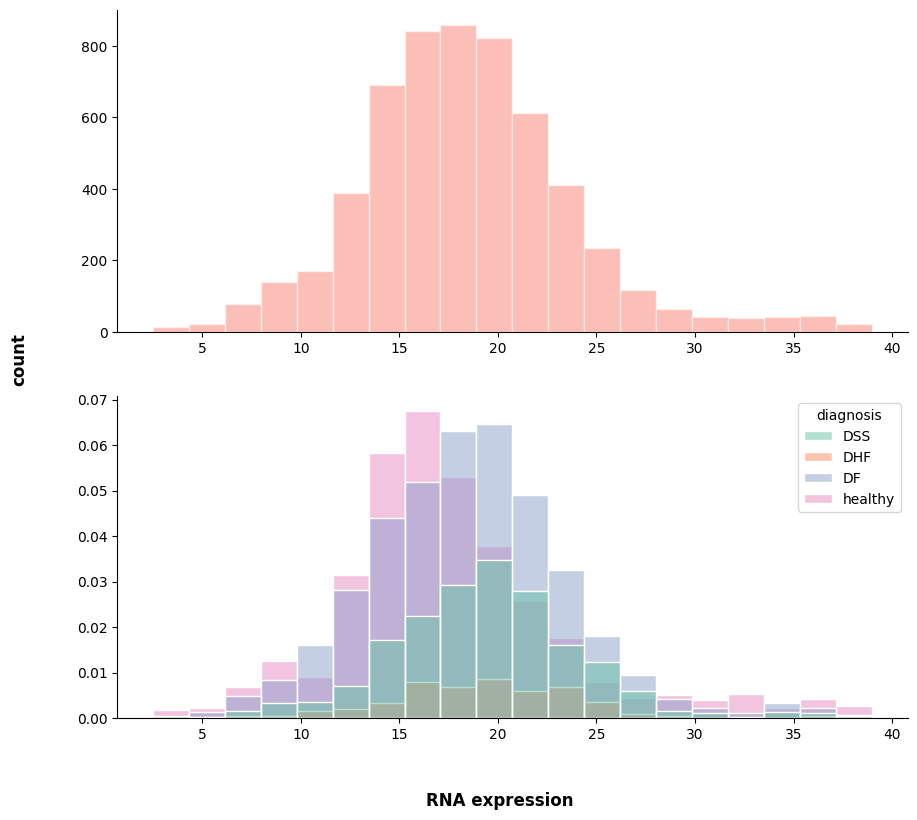

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


gene_expression2_df = gene_expression_df[gene_expression_df.Quality>0]

fig, ax = plt.subplots(2, 1, figsize=(10.2, 9.2))

ax[0].hist(gene_expression2_df["Value"].values, edgecolor="w", facecolor="salmon",
                                                                alpha=0.5, bins=20)

gene_expression2_df["log_Value"] = np.log(gene_expression2_df["Value"].values)
sns.histplot(ax       = ax[1],
            data      = gene_expression2_df,
            x         = "Value",
            hue       = "diagnosis",
            edgecolor = "w",
            bins      = 20,
            stat      = "probability",
            palette   = "Set2")

ax[1].set_xlabel(None)
ax[1].set_ylabel(None)

for axi in ax.flatten():
    axi.spines["top"].set_visible(False)
    axi.spines["right"].set_visible(False)

fig.supxlabel("RNA expression", weight="bold")
fig.supylabel("count", weight="bold")


In [ ]:
def dig2num(diagnosis):
    if diagnosis == "DF":
        return 1
    elif diagnosis == "DHF":
        return 2
    elif diagnosis == "DSS":
        return 3
    else:
        return 0

logistic_reg_df = gene_expression2_df[["patient_ID", "mRNA", "Value", "diagnosis"]]
logistic_reg_df["value_diag"] = logistic_reg_df["diagnosis"].apply(dig2num)

labels_df                  = logistic_reg_df[["patient_ID", "value_diag"]].drop_duplicates().reset_index(drop=True)
labels_df["disease_label"] = labels_df["value_diag"].apply(lambda x: 1 if x>0 else 0)

expression_mat_df  = pd.pivot_table(logistic_reg_df, index="patient_ID", columns="mRNA", values="Value")


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/3602218765.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logistic_reg_df["value_diag"] = logistic_reg_df["diagnosis"].apply(dig2num)


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/2730356464.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gene_anova_df = pd.concat([df, gene_anova_df], ignore_index=True)
/Users/chaosdonkey06/miniconda3/lib/python3.11/site-packages/matplotlib/text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/chaosdonkey06/miniconda3/lib/python3.11/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/ch

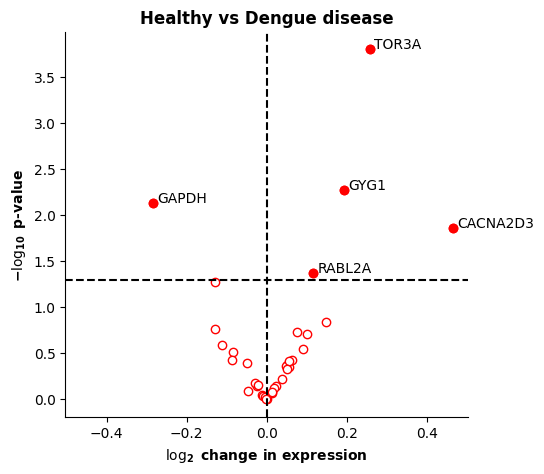

In [ ]:
# Importing library
from scipy.stats import f_oneway

healthy_df    = expression_mat_df.iloc[list(labels_df.disease_label==0), :]
diease_df     = expression_mat_df.iloc[list(labels_df.disease_label==1), :]

gene1_healthy = healthy_df.iloc[:, 0].values
gene1_disease = diease_df.iloc[:, 0].values


gene_anova_df = pd.DataFrame(columns=["gene", "pval", "gene_health_mean", "gene_disease_mean"])
for igene, gene in enumerate(expression_mat_df.columns):

    gene1_healthy = healthy_df.iloc[:, igene].dropna().values
    gene1_disease = diease_df.iloc[:, igene].dropna().values


    anov              = f_oneway(gene1_healthy, gene1_disease)
    pval_gene         = anov.pvalue

    gene_health_mean  = gene1_healthy.mean()
    gene_disease_mean = gene1_disease.mean()


    df = pd.DataFrame([{"gene" :        gene,
                                        "pval":              pval_gene,
                                        "gene_health_mean":  gene_health_mean,
                                        "gene_disease_mean": gene_disease_mean}])
    gene_anova_df = pd.concat([df, gene_anova_df], ignore_index=True)

gene_anova_df["log2_expression"] = np.log2(gene_anova_df["gene_disease_mean"]/gene_anova_df["gene_health_mean"])


fig, ax = plt.subplots(1, 1, figsize=(5.2, 5))

ax.scatter(gene_anova_df["log2_expression"], -np.log10(gene_anova_df["pval"]), fc="w", ec="r")
ax.axhline(-np.log10(0.05), color="k", ls="--")
ax.axvline(x=0, color="k", ls="--")

for gene in  gene_anova_df[gene_anova_df["pval"]<0.05].gene.values:
    row = gene_anova_df[gene_anova_df["gene"]==gene]

    ax.scatter(row.log2_expression,   -np.log10(row.pval), fc="r", ec="r")
    ax.text(row.log2_expression+1e-2, -np.log10(row.pval)+1e-2, gene)

#ax.text(-0.4, -np.log10(0.05), r"$\uparrow$ significant")

ax.set_xlabel(r"$\mathbf{{\log_2}}$ change in expression", weight="bold")
ax.set_ylabel(r"$\mathbf{{-\log_{10}}}$ p-value", weight="bold")

ax.set_title("Healthy vs Dengue disease", weight="bold")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim(-np.max(np.abs(ax.get_xlim())), np.max(np.abs(ax.get_xlim())))

fig.savefig(os.path.join("figures", "anova_dengue_gene_expression.png"), dpi=300, bbox_inches="tight")

In [ ]:
gene_anova_df


,gene,pval,gene_health_mean,gene_disease_mean,log2_expression
0,TRERF1,0.258631,21.843463,20.226401,-0.110962
1,TOR3A,0.000157,14.950132,17.868967,0.257298
2,TMEM63C,0.425588,21.525868,22.281137,0.049751
3,SPON2,0.447798,17.627001,18.318145,0.055486
4,SOX13,0.187246,19.353881,20.394130,0.075531
5,SERINC5,0.708216,16.148016,15.882140,-0.023952
6,RABL2A,0.042455,20.603166,22.336597,0.116543
7,PTPRM,0.406663,19.321389,18.664787,-0.049880
8,NCR3,0.887932,17.838803,17.704978,-0.010864
9,MCL1,0.910251,10.939153,10.861809,-0.010237


In [ ]:
gene_anova_df

,gene,pval,gene_health_mean,gene_disease_mean,log2_expression
0,TRERF1,0.258631,21.843463,20.226401,-0.110962
1,TOR3A,0.000157,14.950132,17.868967,0.257298
2,TMEM63C,0.425588,21.525868,22.281137,0.049751
3,SPON2,0.447798,17.627001,18.318145,0.055486
4,SOX13,0.187246,19.353881,20.394130,0.075531
5,SERINC5,0.708216,16.148016,15.882140,-0.023952
6,RABL2A,0.042455,20.603166,22.336597,0.116543
7,PTPRM,0.406663,19.321389,18.664787,-0.049880
8,NCR3,0.887932,17.838803,17.704978,-0.010864
9,MCL1,0.910251,10.939153,10.861809,-0.010237


# PCA

In [ ]:
# X = feature values, all the columns except the last column
x_mat = expression_mat_df.iloc[:, :]
μ_x   = np.nanmean(x_mat, axis=0)
σ_x   = np.nanstd(x_mat, axis=0)

xn_mat = (x_mat - μ_x) / σ_x
xn_mat = np.c_[np.ones((xn_mat.shape[0], 1)), xn_mat] ## augment with column of ones
y_vec  = labels_df.iloc[:, -1].to_numpy()


Text(0, 0.5, 'principal component 2, 1.69%')

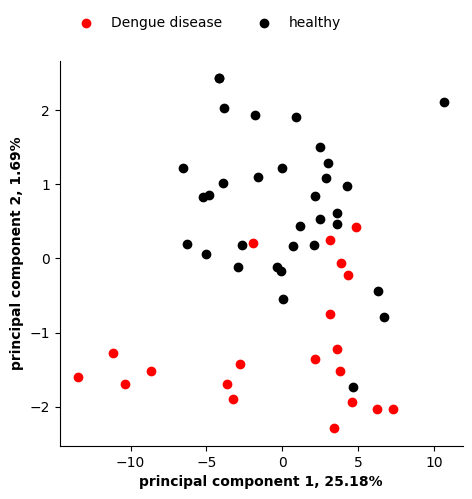

In [ ]:
from sklearn.decomposition import PCA
pca_mRNA_denv = PCA(n_components=2, svd_solver='arpack')
pc_mRNA       = pca_mRNA_denv.fit_transform(np.nan_to_num(xn_mat[:, 1:]))


label2color = {0:"red", 1:"black"}
y_color     = [label2color[y] for y in y_vec]

pca_df          = pd.DataFrame(data = pc_mRNA, columns = ['pc1', 'pc2'])
pca_df["color"] = y_color

fig, ax = plt.subplots(1, 1, figsize=(5.2, 5))

labels = ["Dengue disease", "healthy"]
for ic, c in enumerate(["red", "black"]):
    pca_plot_df = pca_df[pca_df.color == c]
    ax.scatter(pca_plot_df.pc1, pca_plot_df.pc2, color=c, label=labels[ic])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.legend(loc="upper left", bbox_to_anchor=(0, 1.15), ncol=2, frameon=False)

exp_var = pca_mRNA_denv.explained_variance_

ax.set_xlabel("principal component 1, {:0.2f}%".format(exp_var[0]), weight="bold")
ax.set_ylabel("principal component 2, {:0.2f}%".format(exp_var[1]), weight="bold")


In [ ]:
pca_mRNA_denv = PCA(n_components=20, svd_solver='arpack')
pc_mRNA       = pca_mRNA_denv.fit_transform(np.nan_to_num(xn_mat[:,1:]))

dfLoadings = pd.DataFrame(pca_mRNA_denv.components_,
                          columns = expression_mat_df.columns,
                          index   = [f"pc{i}" for i in range(1, 20+1)])


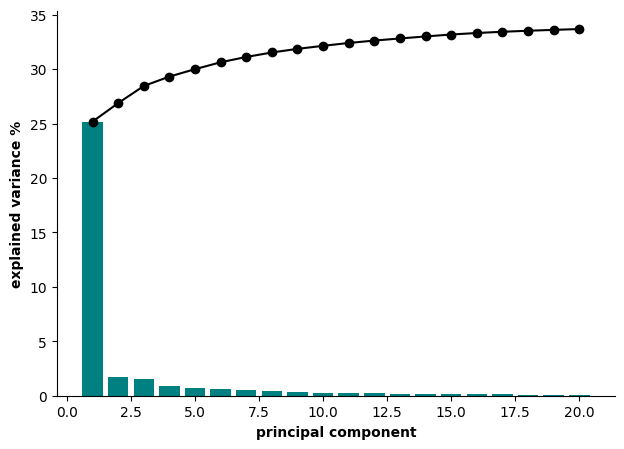

In [ ]:
pca_mRNA_denv.explained_variance_

fig, ax = plt.subplots(1, 1, figsize=(7.2, 5))

ax.bar(range(1,     len(pca_mRNA_denv.explained_variance_ratio_)+1), pca_mRNA_denv.explained_variance_, color="teal")
ax.plot(range(1,    len(pca_mRNA_denv.explained_variance_ratio_)+1), np.cumsum(pca_mRNA_denv.explained_variance_), color="k", ls="-")
ax.scatter(range(1, len(pca_mRNA_denv.explained_variance_ratio_)+1), np.cumsum(pca_mRNA_denv.explained_variance_), color="k")

ax.set_ylabel("explained variance %", weight="bold")
ax.set_xlabel("principal component", weight="bold")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


# Logistic regression

In [ ]:
from scipy.optimize import fmin_tnc

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def prob(theta, x):
    return sigmoid(np.dot(x, theta))

def objective(theta, x, y):
    # Computes the (negative of the) objective function, for all the training samples
    p = prob(theta, x)
    return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

def gradient(theta, x, y):
    # Computes the gradient of the cost function at the point theta values
    return np.dot(x.T, sigmoid(np.dot(x, theta)) - y)

def fit(x, y, theta):
    return fmin_tnc(func=objective, x0=theta, fprime=gradient, args=(x, y))[0]


In [ ]:
θ_0        = np.zeros((xn_mat.shape[1], 1))
theta_star = fit(np.nan_to_num(xn_mat), y_vec, θ_0)
theta_star

  NIT   NF   F                       GTG
    0    1  3.673680056967711E+01   6.95937430E+02
tnc: fscale = 0.0379066
    1    7  8.439503387381260E+00   1.08092711E+01
    2   15  3.498714185454706E+00   9.33878132E+00
tnc: stepmx = 1000
    3   21  5.615568791973501E-01   2.08470538E-01
tnc: fscale = 2.19017
    4   32  1.713889778879964E-01   3.97332513E-02
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/218730214.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/218730214.py:12: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    5   42  2.319591262115973E-02   5.52619721E-04
    6   69  1.442673230037461E-02   2.73671656E-04
tnc: fscale = 60.4484
tnc: |fn-fn-1] = 9.93328e-10 -> convergence
    7  120  1.442673130704693E-02   2.73671625E-04
tnc: Converged (|f_n-f_(n-1)| ~= 0)


array([  6.61123349,   1.99368832,   0.40086874,  -3.17602066,
         1.38242394,   1.2384208 ,   0.63268866,  -7.00071753,
       -12.09088064,   1.6949833 ,   7.79042729,  -5.72484132,
        -6.47699479,  -0.2177381 ,  -2.48800566,  -1.93874584,
         7.65396124,   3.26417218,   9.3501797 ,  -4.27647426,
        -6.77799731,  -6.02129532,  -2.48036447,   8.17666668,
         3.13456322,   9.08685424,  -7.31278099,   3.41444301,
        -3.65637009,  12.89413402,  -2.80396165,   9.83633912,
         0.46311746,  -4.45068477,   1.31809005,   3.32564666])

In [ ]:
def accuracy(x, actual_classes, θ):
    predicted_classes = (prob(θ, x) >= 0.5).astype(int).flatten()
    return 100 * np.mean(predicted_classes == actual_classes)

acc = accuracy(xn_mat, y_vec, theta_star)

print("\n Accuracy {}\n".format(acc))


 Accuracy 58.490566037735846



/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/1461325888.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(expression_mat_df.columns.values, rotation=90)


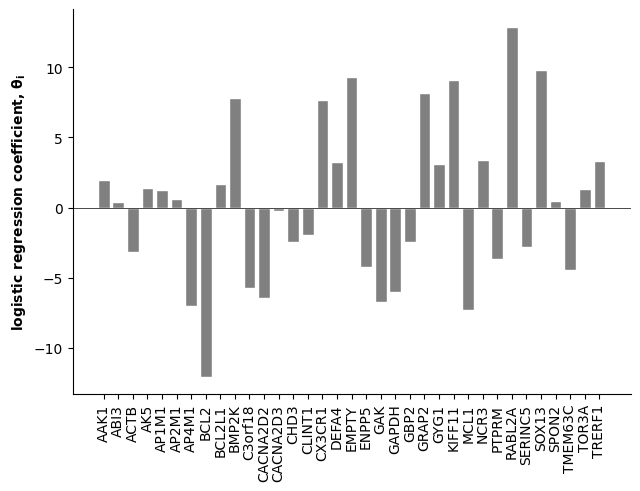

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(7.2, 5))
ax.bar(expression_mat_df.columns.values, theta_star[1:], color="gray", edgecolor="w")

ax.axhline(0, color="k", ls="-", lw=0.5)

ax.set_ylabel(r"logistic regression coefficient, $\mathbf{{\theta_i}}$", weight="bold")
ax.set_xticklabels(expression_mat_df.columns.values, rotation=90)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## logistic regression just on the 5 genes significant ($p_{\text{value}}$ $\leq$ 0.05 ) in the ANOVA (volcano plot)


In [ ]:
genes_diff_exp = ["GAPDH", "TOR3A", "GYG1", "RABL2A", "CACNA2D3"]

x_mat = expression_mat_df[genes_diff_exp].iloc[:, :]
μ_x   = np.nanmean(x_mat, axis=0)
σ_x   = np.nanstd(x_mat, axis=0)

xn_mat = (x_mat - μ_x) / σ_x
xn_mat = np.c_[np.ones((xn_mat.shape[0], 1)), xn_mat] ## augment with column of ones
y_vec  = labels_df.iloc[:, -1].to_numpy()

# regression
θ_0        = np.zeros((xn_mat.shape[1], 1))
θ_star = fit(np.nan_to_num(xn_mat), y_vec, θ_0)
θ_star

acc   = accuracy(xn_mat, y_vec, θ_star)
print("\n Accuracy {}\n".format(acc))



 Accuracy 54.71698113207547



  NIT   NF   F                       GTG
    0    1  3.673680056967711E+01   4.39177197E+02
tnc: fscale = 0.0477178
    1    4  2.150251018172167E+01   2.33389933E+01
    2   10  1.934748093172589E+01   1.59883843E+00
    3   15  1.897576265855573E+01   2.30855401E-01
tnc: fscale = 2.08128
    4   19  1.894701709817349E+01   5.80121131E-03
    5   22  1.894590014293815E+01   4.95592610E-04
tnc: fscale = 44.9198
    6   25  1.894585097634916E+01   4.77840055E-05
    7   29  1.894584273012199E+01   3.80085633E-07
tnc: fscale = 1622.03
    8   33  1.894584257116205E+01   3.72837066E-08
tnc: |fn-fn-1] = 6.53391e-09 -> convergence
    9   36  1.894584256462814E+01   8.69533213E-09
tnc: Converged (|f_n-f_(n-1)| ~= 0)


## logistic regression on the first 20 principal components

In [ ]:
θ_02  = np.zeros((pc_mRNA.shape[1], 1))
θ_hat = fit(pc_mRNA, y_vec, θ_02)


  NIT   NF   F                       GTG
    0    1  3.673680056967711E+01   6.52030834E+02
tnc: fscale = 0.0391621
    1    7  1.221296466980589E+01   1.69410269E+02
    2   19  9.439739649628820E+00   4.16125181E+01
    3   22  8.791345249861331E+00   1.10555009E+00
tnc: fscale = 0.951066
    4   30  7.561688151707035E+00   9.89500562E-01
tnc: stepmx = 1000
    5   37  5.986614192294152E+00   1.80143035E+00
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/218730214.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/218730214.py:12: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    6   74  4.478228099657665E+00   4.98267472E-01
tnc: |fn-fn-1] = 1.96991e-10 -> convergence
    7  128  4.478228099460674E+00   4.98267472E-01
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [ ]:
acc   = accuracy(pc_mRNA, y_vec, θ_hat)
print("\n Accuracy {}\n".format(acc))



 Accuracy 96.22641509433963



/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/4244128803.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"PC{i}" for i in range(1, 20)], rotation=90)


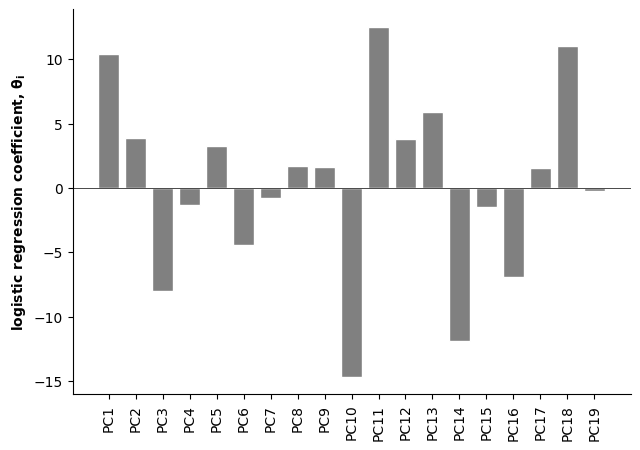

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7.2, 5))
ax.bar([f"PC{i}" for i in range(1, 20)], θ_hat[1:], color="gray", edgecolor="w")

ax.set_ylabel(r"logistic regression coefficient, $\mathbf{{\theta_i}}$", weight="bold")

ax.set_xticklabels([f"PC{i}" for i in range(1, 20)], rotation=90)
ax.axhline(0, color="k", ls="-", lw=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


## cross-validation (and bootstrapping)

textbooks typically introduce both cross-validation and bootstrapping in different sections. They technically are different but the goal of both is the same: estimate expected prediction error.


**cross-validation**

in CV one ideally has a huge dataset that can split in $K$ partitions each one with the same number of training samples. Given those partitions, the training procedure involves training a model in the data that belongs to $K-1$ partitions and using the one left out for testing. That way you'll end with $K$ models trained and the expected prediction accuracy is just the average accuracy across the partitions.

**bootstrapping**

Bootstrapping corresponds to a sampling procedure of a fixed dataset as described below. I like to think of this method as a Monte Carlo method where the distribution to sample is the empirical distribution given by the dataset and thus random sampling is equivalent to drawing from that distribution. As a consequence, the estimate of the prediction accuracy also has embedded information of the variance of that accuracy, a Monte Carlo estimate specifically. Thus, cross-validation allows an estimate of the variance of the prediction accuracy.


Additionally, typically it is hard to have huge sample sizes of observed phenomena, like the Dengue disease case where clinical cases due to severe disease are a small ($\sim$ 10\%) sample of the true infections. and thus the bootstrapping language is preferred.


the idea here is to created $K$ models trained on $N-T$ train samples where $N$ is the size of the data set and $T$ the size of the test set.


the $N-T$ train samples are drawn with resample from the dataset, so each training set represents a random population sample and so does the test set.


in reality of course is not random as $P(\text{blood sample}|\text{disease})$ is way bigger than $P(\text{blood sample}|\text{healthy})$ in real life, but we don't know those numbers so far so bootstrapping (cross-validation) is the best we can do to estimate the test error/accuracy.


This estimate is in theory a statistical, unbiased $\left(\mathbb{E}[\hat{\text{error}}] = \text{error}\right)$, estimate of the test error in IID population, which is generally not the case but still is the best we can do.



In [ ]:
def cross_val_indexes(n, n_train_frac=80, K=30):

    n_train = int(n * n_train_frac / 100)
    n_test  = n - n_train

    train_indexes = np.full((K, n_train), np.nan)
    test_indexes  = np.full((K, n_test), np.nan)

    indexes = np.arange(n)
    for ki in range(K):

        train_indexes[ki, :] = np.random.choice(indexes, n_train, replace=True)
        test_index           = list(set(indexes) - set(train_indexes[ki, :]))
        test_indexes[ki, :]  = np.random.choice(test_index, n_test, replace=True)

    return np.asarray(train_indexes, dtype=int),  np.asarray(test_indexes, dtype=int)



In [ ]:
x_mat = expression_mat_df.iloc[:, :]
μ_x   = np.nanmean(x_mat, axis=0)
σ_x   = np.nanstd(x_mat, axis=0)

xn_mat = (x_mat - μ_x) / σ_x
xn_mat = np.c_[np.ones((xn_mat.shape[0], 1)), xn_mat] ## augment with column of ones
y_vec  = labels_df.iloc[:, -1].to_numpy()

K   = 300
train_indexes, test_indexes = cross_val_indexes(n=len(expression_mat_df), n_train_frac=80, K=K)

θ0 = np.zeros((xn_mat.shape[1], 1))

θ_cv       = np.full((K, xn_mat.shape[1]), np.nan)
accu_train = np.full(K, np.nan)
accu_test  = np.full(K, np.nan)

for ki in range(K):

    train_set = train_indexes[ki, :]
    test_set  = test_indexes[ki, :]

    xn_train  = np.nan_to_num(xn_mat[train_set, :])
    y_train   = y_vec[train_set]

    xn_test  = np.nan_to_num(xn_mat[test_set, :])
    y_test   = y_vec[test_set]

    θ           = fit(xn_train, y_train, θ0)
    θ_cv[ki, :] = θ

    acc_train = accuracy(xn_train, y_train, θ)
    acc_test  = accuracy(xn_test, y_test, θ)

    accu_train[ki] = acc_train
    accu_test[ki]  = acc_test


  NIT   NF   F                       GTG
    0    1  2.911218158351770E+01   1.03149725E+03
tnc: fscale = 0.0311362
    1    5  8.616371744299615E+00   4.70188856E+01
    2    9  3.478009276934727E+00   3.56941606E+01
    3   14  4.987774902073457E-01   1.55107356E+00
tnc: fscale = 0.802941
    4   21  1.280284331906830E-01   5.57127567E-02
    5   28  1.596032310458143E-02   4.55165176E-03
tnc: stepmx = 1000
    6   35  6.107381847400487E-04   1.91669301E-06
tnc: fscale = 722.31
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/218730214.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/218730214.py:12: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    7   58  3.442657361989706E-04   4.05367321E-07
tnc: |fn-fn-1] = 7.30758e-10 -> convergence
    8   99  3.442650054410502E-04   

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/3870931505.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(θ_cv[:, :],


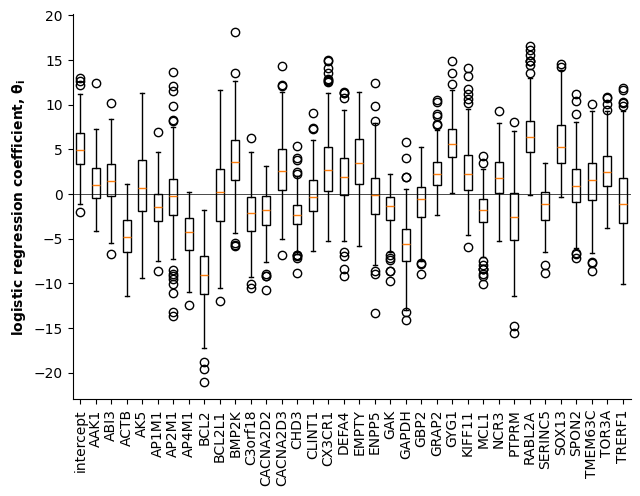

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7.2, 5))

bplot = ax.boxplot(θ_cv[:, :],
                patch_artist = True,  # fill with color
                labels       = ["intercept"]+list(expression_mat_df.columns.values))  # will be used to label x-ticks

ax.set_ylabel(r"logistic regression coefficient, $\mathbf{{\theta_i}}$", weight="bold")
ax.set_xticklabels(["intercept"]+list(expression_mat_df.columns.values), rotation=90)
ax.axhline(0, color="k", ls="-", lw=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# fill with colors.
for patch in bplot['boxes']:
    patch.set_facecolor("w")
    patch.set_edgecolor("k")


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/3192926391.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot1 = ax[0].boxplot(accu_train,
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_10160/3192926391.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot2 = ax[1].boxplot(accu_test,


Text(0.02, 0.5, 'accuracy %')

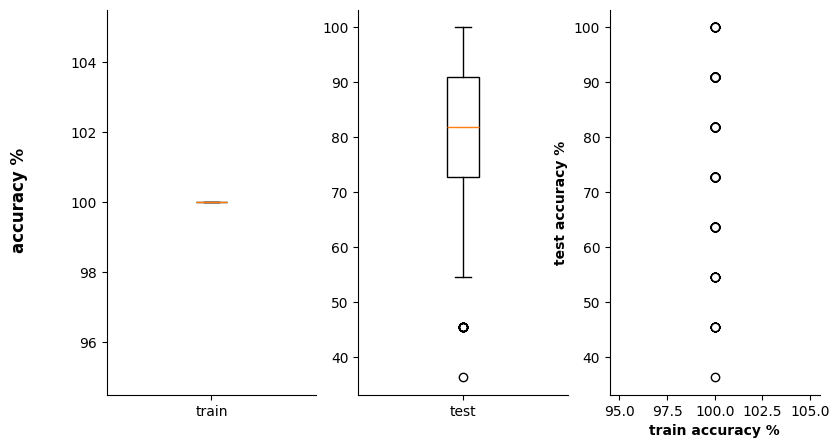

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9.2, 5))

bplot1 = ax[0].boxplot(accu_train,
                    patch_artist = True,          # fill with color
                    labels       = ["train"])     # will be used to label x-ticks
bplot2 = ax[1].boxplot(accu_test,
                        patch_artist = True,      # fill with color
                        labels       = ["test"])  # will be used to label x-ticks

ax[2].scatter(accu_train, accu_test, fc="w", ec="k")

for axi in ax.flatten():
    axi.spines["right"].set_visible(False)
    axi.spines["top"].set_visible(False)

# fill with colors
for patch in bplot1['boxes']:
    patch.set_facecolor("w")
    patch.set_edgecolor("k")

for patch in bplot2['boxes']:
    patch.set_facecolor("w")
    patch.set_edgecolor("k")

ax[2].set_xlabel("train accuracy %", weight="bold")
ax[2].set_ylabel("test accuracy %", weight="bold")

fig.supylabel("accuracy %", weight="bold")